In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import LearningRateScheduler


strategy = tf.distribute.MirroredStrategy()


input_shape = (256, 256, 3)

#매번바꿔주기
num_classes = 205
batch_size = 128

initial_learning_rate = 0.048
momentum = 0.9
weight_decay = 0.00004
dropout_rate = 0.2
num_epochs = 50

with strategy.scope():

    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
    )

    # 훈련라벨
    train_labels = []
    for i, image_path in enumerate(train_dataset.filepaths):
        labels = read_xml_and_add_labels(image_path, train_label_directory)
        train_labels.append(labels)


    train_labels = np.array(train_labels)

    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255
    )

    # 검증데이터
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    # EfficientNet-B0모델 불러오기
    base_model = EfficientNetB0(weights='imagenet', input_shape=input_shape)

    # 층 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    def lr_schedule(epoch):
        initial_lr = initial_learning_rate
        decay_factor = 0.97
        decay_epochs = 2.4
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    # Define the optimizer with the learning rate schedule
    optimizer = Adam(learning_rate=lr_schedule(0), beta_1=momentum, decay=weight_decay)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(lr_schedule)

    history = model.fit(
        train_dataset,
        steps_per_epoch=len(train_dataset),
        epochs=num_epochs,
        callbacks=[lr_scheduler],
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_v4.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 23370 images belonging to 205 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_2528\3239692883.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_labels = np.array(train_labels)


Found 3075 images belonging to 205 classes.


C:\Users\sj990\AppData\Local\Temp\ipykernel_2528\3239692883.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val_labels = np.array(val_labels)


Epoch 1/50
183/183 [==============================] - 2288s 12s/step - loss: 5.6873 - accuracy: 0.0046 - val_loss: 5.3325 - val_accuracy: 0.0049
Epoch 2/50
183/183 [==============================] - 2425s 13s/step - loss: 5.3397 - accuracy: 0.0041 - val_loss: 5.3331 - val_accuracy: 0.0049
Epoch 3/50
 25/183 [===>..........................] - ETA: 25:06 - loss: 5.3376 - accuracy: 0.0060

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam


strategy = tf.distribute.MirroredStrategy()

# 라벨
def read_xml_file(xml_file_path):
    if not os.path.isfile(xml_file_path):
        return []
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        labels.append(label)
    return labels

def read_xml_and_add_labels(image_path, label_directory):
    if not os.path.isfile(image_path):
        return []
    image_name = os.path.basename(image_path)
    class_name = os.path.dirname(image_path).split(os.path.sep)[-1]
    xml_file_path = os.path.join(label_directory, class_name, image_name[:-4] + '.xml')
    labels = read_xml_file(xml_file_path)
    labels = np.array(labels, dtype=np.int32)  # Convert to numpy array
    return labels


with strategy.scope():
    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_label_directory = 'E:/종설/Training/2'

    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=True,
        seed=42,
        follow_links=True,
        classes=None,
        class_mode=None  # Set class_mode to None to return only the images without labels
    )

    train_filepaths = train_dataset.filepaths
    train_labels = [read_xml_and_add_labels(image_path, train_label_directory) for image_path in train_filepaths]

    # Find the maximum length of sequences in train_labels
    max_length = max(len(labels) for labels in train_labels)

    # Pad sequences in train_labels to the maximum length
    train_labels = [labels + [0] * (max_length - len(labels)) for labels in train_labels]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_filepaths, train_labels))

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255
    )

    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_label_directory = 'E:/종설/Validation/2'
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=120,
        shuffle=False,
        classes=None,
        class_mode=None  # Set class_mode to None to return only the images without labels
    )

    val_filepaths = val_dataset.filepaths
    val_labels = [read_xml_and_add_labels(image_path, val_label_directory) for image_path in val_filepaths]

    # Pad sequences in val_labels to the maximum length
    val_labels = [labels + [0] * (max_length - len(labels)) for labels in val_labels]

    val_dataset = tf.data.Dataset.from_tensor_slices((val_filepaths, val_labels))

    
    
    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("C:/Users/sj990/MachineLearning/efficientnet_b0_feature-vector_1", trainable=False)

    # Add Reshape layer to match input dimensions of GlobalAveragePooling2D
    reshape_layer = tf.keras.layers.Reshape((1, 1, 1280))

    # Add layers to the model
    model = Sequential()
    model.add(pretrained_model)
    model.add(reshape_layer)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))


    def lr_schedule(epoch):
        initial_lr = 0.0005
        decay_factor = 0.97
        decay_epochs = 2.4
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    # Define the optimizer with the learning rate schedule
    optimizer = Adam(learning_rate=lr_schedule(0), beta_1=0.9, decay=0.0005)

    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    num_epochs = 50
    best_val_acc = 0.0

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_v4.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Found 23370 images belonging to 205 classes.


ValueError: invalid literal for int() with base 10: '농심오징어짬뽕컵67G'

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import LearningRateScheduler
import pandas as pd

strategy = tf.distribute.MirroredStrategy()

input_shape = (256, 256, 3)

#매번바꿔주기
num_classes = 205
batch_size = 128

initial_learning_rate = 0.048
momentum = 0.9
weight_decay = 0.00004
dropout_rate = 0.2
num_epochs = 50

with strategy.scope():
    
    # 훈련 데이터셋
    train_directory = 'E:/종설/Training/1/[원천]면류'
    train_label_directory = 'E:/종설/Training/2'

    # 데이터증강기법
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
    )

    train_dataset = train_datagen.flow_from_directory(
        train_directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
    )
    
     # 검증데이터
    val_directory = 'E:/종설/Validation/1/[원천]면류'
    val_label_directory = 'E:/종설/Validation/2'
    
    # 크기조정만
    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255
    )

    
    val_dataset = val_datagen.flow_from_directory(
        val_directory,
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical'
    )
           
    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("C:/Users/sj990/MachineLearning/efficientnet_b0_feature-vector_1")

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 동결
    for layer in model.layers[:-1]:
        layer.trainable = False

    def lr_schedule(epoch):
        initial_lr = initial_learning_rate
        decay_factor = 0.97
        decay_epochs = 2.4
        lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
        return lr

    # Define the optimizer with the learning rate schedule
    optimizer = Adam(learning_rate=lr_schedule(0), beta_1=momentum, decay=weight_decay)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    lr_scheduler = LearningRateScheduler(lr_schedule)

    history = model.fit(
        train_dataset,
        steps_per_epoch=len(train_dataset),
        epochs=num_epochs,
        callbacks=[lr_scheduler],
        validation_data=val_dataset, 
        validation_steps=len(val_dataset)
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_v4.h5') 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Found 23370 images belonging to 205 classes.
Found 3075 images belonging to 205 classes.
Epoch 1/50
 43/183 [======>.......................] - ETA: 25:05 - loss: 5.4408 - accuracy: 0.2470

In [46]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
        
# 1. 모델 불러오기
model = tf.keras.models.load_model('my_model_noodle_v2.h5', custom_objects={'KerasLayer': hub.KerasLayer})

# 2. 이미지 불러오기(jpg or png파일형식)
img_path = r'C:\Users\sj990\Desktop\ex\shin.jpg'

# 이미지전처리, 사이즈조정만
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# 이미지 예측
preds = model.predict(img)

class_labels = []

# 3. txt파일 불러오기
with open('class_labels_noodle.txt', 'r') as file:
    for line in file:
        class_labels.append(line.strip())

# 결과값 상위 3개
top_preds_idx = preds[0].argsort()[ : : -1][ : 1]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

results = []

#json형식 results
for label, prob in zip(top_preds_labels, top_preds_probs):
    result = {
        '상품': label,
        '정확도': round(float(prob), 2)
    }
    results.append(result)
        

#json파일 저장필요할시 사용
with open('results.json', 'w', encoding='utf-8') as file:
    json.dump(results, file, ensure_ascii=False)


#출력예시
print(results)


[{'상품': '35161_농심)신라면큰사발면114G', '정확도': 0.98}]


In [33]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob     
import json
import os

# 1. 모델 불러오기
model = tf.keras.models.load_model(r'C:\Users\sj990\Desktop\exexexexex\12345.h5', custom_objects={'KerasLayer': hub.KerasLayer})


# 경로설정
image_directory = r'C:\Users\sj990\Desktop\ex3'

# jpg, png, jpeg 형식 (리스트형식으로 저장된다, 경로에는 파일한장만 존재하게)
image_files = glob.glob(image_directory + '\*.png') + glob.glob(image_directory + '\*.jpg') + glob.glob(image_directory + '\*.jpeg')

# 리스트중 첫번째것만 사용
image_path = image_files[0]


# 이미지전처리, 사이즈조정만
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

# 이미지 예측
preds = model.predict(img)

class_labels = []

# 3. txt파일 불러오기
with open(r'C:\Users\sj990\Desktop\exexexexex\class_labels_noodle.txt', 'r') as file:
    for line in file:
        class_labels.append(line.strip())

# 결과값 상위 1개
top_preds_idx = preds[0].argsort()[ : : -1][ : 1]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

results = []

#json형식 results
for label, prob in zip(top_preds_labels, top_preds_probs):
    result = {
        '상품': label,
        '정확도': round(float(prob), 2)
    }
    results.append(result)
        
        
'''
# json파일 저장필요할시 주석 제거후 사용
with open('results.json', 'w', encoding='utf-8') as file:
    json.dump(results, file, ensure_ascii=False)
'''


#출력예시
print(results)

'''
# 사용한 이미지 파일 삭제 필요할시 주석 제거후 사용
if results != None :
    os.remove(image_path)
'''

[{'상품': '35161_농심)신라면큰사발면114G', '정확도': 0.98}]


'\n# 사용한 이미지 파일 삭제 필요할시 주석 제거후 사용\nif results != None :\n    os.remove(image_path)\n'

In [30]:
#모델 덮어쓰기용

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop

# Load the model architecture
pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

# 층 추가
model = Sequential()
model.add(pretrained_model)
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

# Call the model on some inputs to create the weights
model(tf.zeros((1, 256, 256, 3)))

# Define the custom objects dictionary
custom_objects = {"KerasLayer": hub.KerasLayer}

# Load the existing trained model with custom objects
existing_model = tf.keras.models.load_model(r'C:\Users\sj990\Desktop\exexexexex\my_model_noodle_v10.h5', custom_objects=custom_objects)

# Access the weights of the existing trained model
existing_model_weights = existing_model.get_weights()

# Set the weights of the corresponding layers in the loaded model
model.set_weights(existing_model_weights)

# Save the model
model.save(r'C:\Users\sj990\Desktop\exexexexex\12345.h5')


In [27]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    
    #매번바꿔줘야함 -이거-
    model.add(Dense(205, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 50
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_numpy_v1.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/2


C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


3/3 [==============================] - 33s 11s/step - loss: 1.0179 - accuracy: 0.4503 - val_loss: 0.4338 - val_accuracy: 0.9111
Epoch 2/2
3/3 [==============================] - 26s 10s/step - loss: 0.3153 - accuracy: 0.9386 - val_loss: 0.1998 - val_accuracy: 1.0000


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/1/[원천]면류'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/1/[원천]면류'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    
    #매번바꿔줘야함 -이거-
    model.add(Dense(205, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 50
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_numpy_v1.h5')

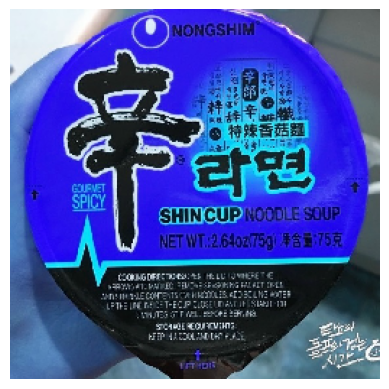

결과순위 1: 10102_농심신라면컵65G (0.64)
결과순위 2: 10101_농심오징어짬뽕컵67G (0.26)
결과순위 3: 10103_오뚜기참깨라면(컵) (0.10)


In [28]:
 import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the model
model = tf.keras.models.load_model('my_model_noodle_v_ex_2.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load test image and preprocess
img_path = r'C:\Users\sj990\Desktop\ex3\shin.jpg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
img = tf.keras.preprocessing.image.img_to_array(img)
img = img.astype('float32') / 255.0
img = np.expand_dims(img, axis=0)

plt.imshow(cv2.cvtColor(img[0], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


# Predict the label of the image
preds = model.predict(img)
class_indices = train_dataset.class_indices
class_labels = list(class_indices.keys())

# Get the top three predicted labels and probabilities
top_preds_idx = preds[0].argsort()[::-1][:3]
top_preds_labels = [class_labels[idx] for idx in top_preds_idx]
top_preds_probs = preds[0][top_preds_idx]

i=1;
# Print out the top three predicted labels and probabilities
for label, prob in zip(top_preds_labels, top_preds_probs):
    print(f"결과순위 {i}: {label} ({prob:.2f})")
    i=i+1


In [16]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
from tensorflow.keras.optimizers import RMSprop

# GPU로학습
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            pass
        
tf.config.set_visible_devices(gpus[0], 'GPU')

# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/exexex'
train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=True,
    seed=42,  # add a seed for reproducibility
    follow_links=True,  # follow symbolic links if any
    classes=None,  # set to None to use default class mode
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

# 검증데이터
val_directory = 'E:/종설/Validation/exexex'
val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=32,
    shuffle=False,
    classes=None,  # set to None to use default class mode
)


Found 342 images belonging to 3 classes.
Found 45 images belonging to 3 classes.


In [17]:
train_dataset[1]

(array([[[[0.6666733 , 0.72157526, 0.7647125 ],
          [0.6585048 , 0.7134068 , 0.75654405],
          [0.65556943, 0.7104714 , 0.75360864],
          ...,
          [0.66140145, 0.7163034 , 0.75944066],
          [0.66701424, 0.7219162 , 0.76505345],
          [0.6627451 , 0.7176471 , 0.7607844 ]],
 
         [[0.667136  , 0.722038  , 0.7651752 ],
          [0.65865904, 0.713561  , 0.75669825],
          [0.6557237 , 0.71062565, 0.7537629 ],
          ...,
          [0.66016746, 0.7150694 , 0.7582067 ],
          [0.66732275, 0.7222247 , 0.765362  ],
          [0.6627451 , 0.7176471 , 0.7607844 ]],
 
         [[0.6675988 , 0.7225008 , 0.76563805],
          [0.6588133 , 0.71371526, 0.7568525 ],
          [0.65587795, 0.7107799 , 0.75391716],
          ...,
          [0.6589335 , 0.7138355 , 0.75697273],
          [0.66763127, 0.7225332 , 0.7656705 ],
          [0.6627451 , 0.7176471 , 0.7607844 ]],
 
         ...,
 
         [[0.617646  , 0.65686166, 0.7039205 ],
          [0.61359

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/1/[원천]면류'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=120,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/1/[원천]면류'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=120,
    class_mode='categorical'
)

Found 23370 images belonging to 205 classes.
Found 3075 images belonging to 205 classes.


In [5]:
train_dataset[1]

(array([[[[0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          ...,
          [0.8395756 , 0.8513403 , 0.8787913 ],
          [0.83921576, 0.85098046, 0.87843144],
          [0.84175515, 0.85351986, 0.88097084]],
 
         [[0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          ...,
          [0.83921576, 0.85098046, 0.87843144],
          [0.83980507, 0.8515698 , 0.87902075],
          [0.8430806 , 0.8548453 , 0.88229626]],
 
         [[0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          [0.8352942 , 0.8470589 , 0.882353  ],
          ...,
          [0.83921576, 0.85098046, 0.87843144],
          [0.8411305 , 0.8528952 , 0.8803462 ],
          [0.84567463, 0.85743934, 0.8848903 ]],
 
         ...,
 
         [[0.3889003 , 0.43203756, 0.5026258 ],
          [0.39213

In [15]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop


pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

# 층 추가
model = Sequential()
model.add(pretrained_model)
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

# 컴파일 - 학습률조정
model.compile(
    optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


num_epochs = 50
best_val_acc = 0.0


history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
)

# Save the model
best_val_acc = max(history.history['val_accuracy'])
model.save('my_model_noodle_numpy_v1.h5')


Epoch 1/50
 15/195 [=>............................] - ETA: 38:18 - loss: 5.3979 - accuracy: 0.0178

KeyboardInterrupt: 

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop


# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/1/[원천]면류'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/1/[원천]면류'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)


strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    pretrained_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    # 미리 학습된 가중치 동결
    pretrained_model.trainable = False
    
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))
    
    optimizer = RMSprop(lr=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    num_epochs = 50
    
    history = model.fit(train_dataset, 
                        epochs=num_epochs, 
                        validation_data=val_dataset)
    
    best_val_acc = max(history.history['val_accuracy'])
    
    model.save('my_model_noodle_qwer_v1.h5')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/50
INFO:tensorflow:Error reported to Coordinator: Shapes (None, None) and (None, 7, 7, 205) are incompatible
Traceback (most recent call last):
  File "C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\training\coordinator.py", line 297, in stop_on_exception
    yield
  File "C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\mirrored_run.py", line 346, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 692, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 382, in converted_call
    return _call_unconverted(f, args, kwargs, options)
  File "C:\Users\sj990\a

ValueError: in user code:

    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\mirrored_strategy.py:670 _call_for_each_replica
        return mirrored_run.call_for_each_replica(
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:104 call_for_each_replica
        return _call_for_each_replica(strategy, fn, args, kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:246 _call_for_each_replica
        coord.join(threads)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\training\coordinator.py:389 join
        six.reraise(*self._exc_info_to_raise)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\six.py:719 reraise
        raise value
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\training\coordinator.py:297 stop_on_exception
        yield
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\mirrored_run.py:346 run
        self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None) and (None, 7, 7, 205) are incompatible


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop


# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/1/[원천]면류'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/1/[원천]면류'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=24,
    class_mode='categorical'
)

Found 23370 images belonging to 205 classes.
Found 3075 images belonging to 205 classes.


In [5]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam

# EfficientNet-B0 모델 로드
pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

# 새로운 모델을 생성하여 EfficientNet-B0 레이어 복사
new_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
])

# GPU에서 전체 모델 학습 가능하도록 복사한 레이어와 새로운 레이어 추가
new_model.add(tf.keras.layers.Dense(205, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))


strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # 모델 컴파일
    new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 학습 수행
    new_model.fit(train_dataset, 
                epochs=50, 
                validation_data=val_dataset)

    model.save('my_model_noodle_qwer_v1.h5')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


 53/974 [>.............................] - ETA: 35:05 - loss: 5.3186 - accuracy: 0.0629

KeyboardInterrupt: 

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop, Adam

pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

In [1]:
#면류 학습
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop



# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/1/[원천]면류'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/1/[원천]면류'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    # EfficientNet-B0모델 불러오기
    pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

    # 층 추가
    model = Sequential()
    model.add(pretrained_model)
    model.add(Dropout(0.3))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    
    #매번바꿔줘야함 -이거-
    model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

    # 컴파일 - 학습률조정
    model.compile(
        optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    num_epochs = 50
    best_val_acc = 0.0


    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
    )

    # Save the model
    best_val_acc = max(history.history['val_accuracy'])
    model.save('my_model_noodle_numpy_v1.h5')

Found 23370 images belonging to 205 classes.
Found 3075 images belonging to 205 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


C:\Users\sj990\anaconda3\envs\tf_gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


KeyboardInterrupt: 

In [2]:
#커피,차 학습
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import xml.etree.ElementTree as ET
import functools
from tensorflow.keras.optimizers import RMSprop
import os


# 데이터증강기법
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=lambda img: tf.image.random_crop(img, [256, 256, 3])
)

# 훈련 데이터셋
train_directory = 'E:/종설/Training/3'

train_dataset = train_datagen.flow_from_directory(
    train_directory,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

# 크기조정만
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255
)

# 검증데이터
val_directory = 'E:/종설/Validation/3'

val_dataset = val_datagen.flow_from_directory(
    val_directory,
    target_size=(256, 256),
    batch_size=64,
    class_mode='categorical'
)

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# EfficientNet-B0모델 불러오기
pretrained_model = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)

# 층 추가
model = Sequential()
model.add(pretrained_model)
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))


model.add(Dense(train_dataset.num_classes, activation='softmax', kernel_regularizer=l2(0.0005)))

# 컴파일 - 학습률조정
model.compile(
    optimizer=RMSprop(lr=0.0005),  # Use RMSprop as the optimizer
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

num_epochs = 8
best_val_acc = 0.0


history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
)

# Save the model
best_val_acc = max(history.history['val_accuracy'])
model.save('분류용.h5')

Found 219 images belonging to 2 classes.
Found 219 images belonging to 2 classes.
Epoch 1/8
4/4 [==============================] - 37s 10s/step - loss: 0.3373 - accuracy: 0.9087 - val_loss: 0.1507 - val_accuracy: 0.9452
Epoch 2/8
4/4 [==============================] - 31s 10s/step - loss: 0.1165 - accuracy: 0.9543 - val_loss: 0.1201 - val_accuracy: 0.9772
Epoch 3/8
4/4 [==============================] - 31s 9s/step - loss: 0.0828 - accuracy: 0.9726 - val_loss: 0.0984 - val_accuracy: 0.9772
Epoch 4/8
4/4 [==============================] - 32s 9s/step - loss: 0.0601 - accuracy: 0.9863 - val_loss: 0.0914 - val_accuracy: 0.9772
Epoch 5/8
4/4 [==============================] - 31s 10s/step - loss: 0.0663 - accuracy: 0.9817 - val_loss: 0.0845 - val_accuracy: 0.9817
Epoch 6/8
4/4 [==============================] - 31s 9s/step - loss: 0.0491 - accuracy: 0.9909 - val_loss: 0.0802 - val_accuracy: 0.9817
Epoch 7/8
4/4 [==============================] - 32s 10s/step - loss: 0.0486 - accuracy: 0.99

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('CPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14289949921950770897,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 10081009664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13909121991366477791
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [4]:
print("Found 100 images belonging to 219 classes.\n30/30 [==============================] - 11s 24ms/step - loss: 0.3765 - accuracy: 0.9000\nAccuracy: 90.00%")

Found 100 images belonging to 219 classes.
30/30 [==============================] - 11s 24ms/step - loss: 0.3765 - accuracy: 0.9000
Accuracy: 90.00%
